In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from architecture import VAE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [3]:
latent_dim = 20
model = VAE(latent_dim=latent_dim).to(device)

In [4]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.MSELoss(reduction="sum")(recon_x, x)

    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kl_loss, recon_loss, kl_loss

In [5]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss, recon_loss, kl_loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    avg_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}: Train Loss = {avg_loss:.4f}")
    return avg_loss

def validate(epoch):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss, _, _ = loss_function(recon_batch, data, mu, logvar)
            val_loss += loss.item()
    avg_loss = val_loss / len(test_loader.dataset)
    print(f"Epoch {epoch}: Validation Loss = {avg_loss:.4f}")
    return avg_loss


In [6]:
num_epochs = 10
train_losses, val_losses = [], []

for epoch in range(1, num_epochs+1):
    train_loss = train(epoch)
    val_loss = validate(epoch)
    train_losses.append(train_loss)
    val_losses.append(val_loss)


Epoch 1: Train Loss = 40.9149
Epoch 1: Validation Loss = 28.9951
Epoch 2: Train Loss = 27.4352
Epoch 2: Validation Loss = 26.6319
Epoch 3: Train Loss = 26.0812
Epoch 3: Validation Loss = 25.6918
Epoch 4: Train Loss = 25.3135
Epoch 4: Validation Loss = 25.0732
Epoch 5: Train Loss = 24.8698
Epoch 5: Validation Loss = 24.7868
Epoch 6: Train Loss = 24.5840
Epoch 6: Validation Loss = 24.4835
Epoch 7: Train Loss = 24.3245
Epoch 7: Validation Loss = 24.2026
Epoch 8: Train Loss = 24.1325
Epoch 8: Validation Loss = 24.1744
Epoch 9: Train Loss = 24.0042
Epoch 9: Validation Loss = 24.1798
Epoch 10: Train Loss = 23.8475
Epoch 10: Validation Loss = 23.9415


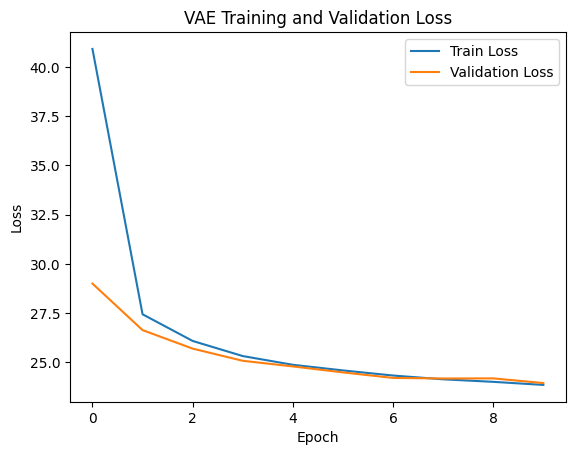

In [7]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("VAE Training and Validation Loss")
plt.show()


In [8]:
#PART 2

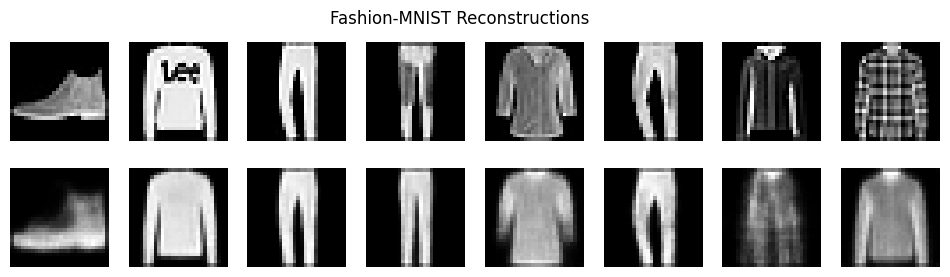

In [9]:
import matplotlib.pyplot as plt

model.eval()
examples = next(iter(test_loader))[0][:8].to(device)      # 8 test samples
with torch.no_grad():
    recon, _, _ = model(examples)

# Plot originals vs reconstructions
fig, axes = plt.subplots(2, 8, figsize=(12, 3))
for i in range(8):
    axes[0, i].imshow(examples[i].cpu().squeeze(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(recon[i].cpu().squeeze(), cmap='gray')
    axes[1, i].axis('off')

axes[0, 0].set_ylabel("Original", fontsize=10)
axes[1, 0].set_ylabel("Recon", fontsize=10)
plt.suptitle("Fashion-MNIST Reconstructions")
plt.show()

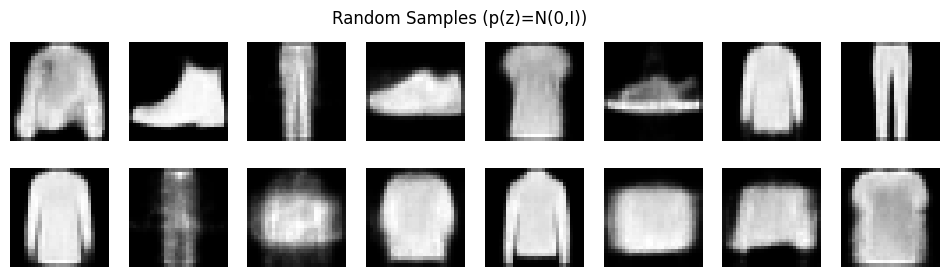

In [10]:
# 16 fresh samples from the prior
z = torch.randn(16, latent_dim).to(device)      # latent_dim matches your model
with torch.no_grad():
    gen = model.decode(z)                       # or model.decoder(z) if separated

# Display
fig, axes = plt.subplots(2, 8, figsize=(12, 3))
for i in range(16):
    axes[i // 8, i % 8].imshow(gen[i].cpu().squeeze(), cmap='gray')
    axes[i // 8, i % 8].axis('off')

plt.suptitle("Random Samples (p(z)=N(0,I))")
plt.show()

In [11]:
# Laplace prior (loc=0, scale=1)
z_laplace = torch.distributions.Laplace(0, 1).sample((16, latent_dim)).to(device)
with torch.no_grad():
    gen_lap = model.decode(z_laplace)

# quick grid plot as above

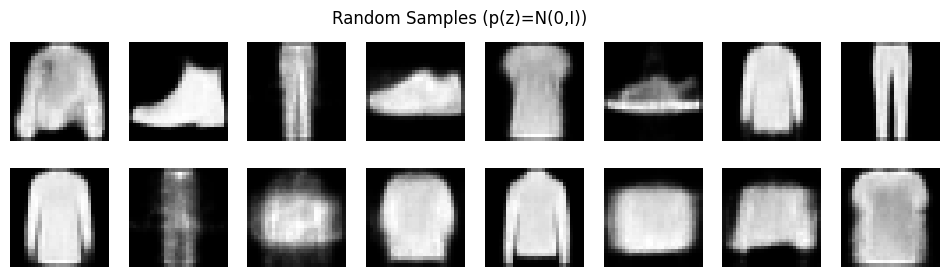

In [12]:
fig, axes = plt.subplots(2, 8, figsize=(12, 3))
for i in range(16):
    axes[i // 8, i % 8].imshow(gen[i].cpu().squeeze(), cmap='gray')
    axes[i // 8, i % 8].axis('off')

plt.suptitle("Random Samples (p(z)=N(0,I))")
plt.show()

In [ ]:
#Part 3

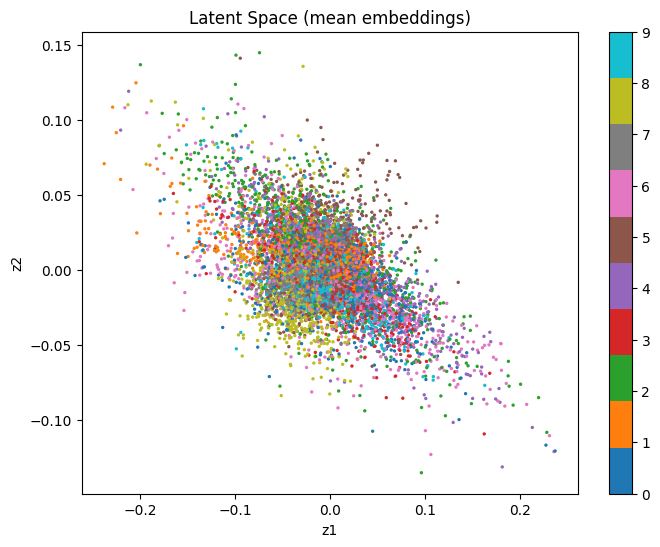

In [14]:
import matplotlib.pyplot as plt
import torch

model.eval()
latents, labels = [], []

with torch.no_grad():
    for x, y in test_loader:
        # run full model but ignore reconstruction
        _, mu, logvar = model(x.to(device))
        latents.append(mu.cpu())
        labels.append(y)

latents = torch.cat(latents)
labels  = torch.cat(labels)

plt.figure(figsize=(8, 6))
plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', s=2)
plt.colorbar()
plt.title("Latent Space (mean embeddings)")
plt.xlabel("z1"); plt.ylabel("z2")
plt.show()

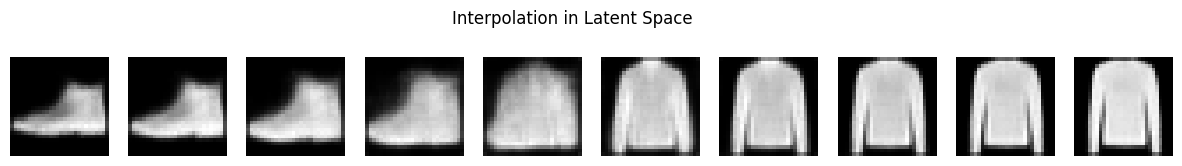

In [15]:
# grab one small batch
x_batch, _ = next(iter(test_loader))
x1, x2 = x_batch[0:1].to(device), x_batch[1:2].to(device)

with torch.no_grad():
    _, mu1, logvar1 = model(x1)
    _, mu2, logvar2 = model(x2)

z1 = mu1
z2 = mu2

# linear walk between z1 and z2
steps = 10
alphas = torch.linspace(0, 1, steps).unsqueeze(1).to(device)   # 10 points
interp_z = (1 - alphas) * z1 + alphas * z2

with torch.no_grad():
    interp_imgs = model.decode(interp_z)   # decoder-only pass

# show the morph
fig, axes = plt.subplots(1, steps, figsize=(15, 2))
for i in range(steps):
    axes[i].imshow(interp_imgs[i].cpu().squeeze(), cmap='gray')
    axes[i].axis('off')

plt.suptitle("Interpolation in Latent Space")
plt.show()


In [ ]:
#Part 4